In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10, FashionMNIST
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_dataset = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [5]:
len(dataloader)

938

In [6]:
inp, out = next(iter(dataloader))

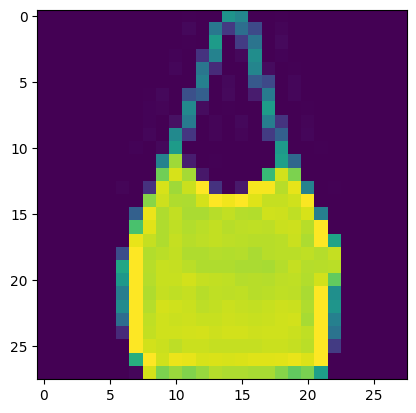

In [7]:
i = np.random.randint(64)
plt.imshow(np.transpose(inp[i], (1, 2, 0)))

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        # input: (batch_size, latent_dim)
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7), # (batch_size, 128 * 7 * 7)
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)), # (batch_size, 128, 7, 7)
            nn.Upsample(scale_factor=2), # (batch_size, 128, 14, 14)
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # (batch_size, 128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (batch_size, 128, 28, 28)
            nn.Conv2d(128, 64, kernel_size=3, padding=1), # (batch_size, 64, 28, 28)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1), # (batch_size, 1, 28, 28)
            nn.Tanh()
        )

    def forward(self, z):
        return self.layers(z)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input: (batch_size, 1, 28, 28)
        self.layers = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=3, stride=2, padding=1), # (batch_size, 28, 14, 14)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(28, 56, kernel_size=3, stride=2, padding=1), # (batch_size, 56, 7, 7)
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(56, momentum=0.82),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Conv2d(56, 112, kernel_size=3, stride=2, padding=1), # (batch_size, 112, 4, 4)
            nn.BatchNorm2d(112, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(112, 224, kernel_size=3, stride=1, padding=1), # (batch_size, 224, 4, 4)
            nn.BatchNorm2d(224, momentum=0.8),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(224 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.layers(img)

In [17]:
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 5

In [11]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
adversarial_loss = nn.BCELoss() # binary loss
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [12]:
generator

Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 7, 7))
    (3): Upsample(scale_factor=2.0, mode='nearest')
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Upsample(scale_factor=2.0, mode='nearest')
    (8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): Tanh()
  )
)

In [13]:
discriminator

Discriminator(
  (layers): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(28, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ZeroPad2d((0, 1, 0, 1))
    (5): BatchNorm2d(56, eps=1e-05, momentum=0.82, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.25)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(56, 112, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(112, eps=1e-05, momentum=0.82, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(112, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(224, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.25)
    (15): Dropout(p=0.25, inplace=False)
    (16): Flatten(start_dim=1, 

In [34]:
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        real_images = batch[0].to(device)
        real = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)
        real_images = real_images.to(device)
        optimizer_D.zero_grad()
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)
        real_loss = adversarial_loss(discriminator(real_images), real)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()
        optimizer_G.zero_grad()
        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), real)
        g_loss.backward()
        optimizer_G.step()
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]", f"Discriminator Loss: {d_loss.item():.4f}", f"Generator Loss: {g_loss.item():.4f}")

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()

Epoch [1/5] Discriminator Loss: 0.6987 Generator Loss: 1.5209
Epoch [1/5] Discriminator Loss: 0.8347 Generator Loss: 1.0163
Epoch [1/5] Discriminator Loss: 0.7772 Generator Loss: 1.5778
Epoch [1/5] Discriminator Loss: 1.0315 Generator Loss: 1.2273
Epoch [1/5] Discriminator Loss: 0.8773 Generator Loss: 1.3814
Epoch [1/5] Discriminator Loss: 1.0297 Generator Loss: 1.3488
Epoch [1/5] Discriminator Loss: 0.9680 Generator Loss: 1.4917
Epoch [1/5] Discriminator Loss: 0.9552 Generator Loss: 1.2650
Epoch [1/5] Discriminator Loss: 1.0753 Generator Loss: 1.2884
Epoch [1/5] Discriminator Loss: 1.0189 Generator Loss: 1.2407
Epoch [1/5] Discriminator Loss: 0.9979 Generator Loss: 1.1463
Epoch [1/5] Discriminator Loss: 0.9285 Generator Loss: 1.7963
Epoch [1/5] Discriminator Loss: 1.1231 Generator Loss: 1.8767
Epoch [1/5] Discriminator Loss: 0.8988 Generator Loss: 1.2995
Epoch [1/5] Discriminator Loss: 1.0021 Generator Loss: 1.7285
Epoch [1/5] Discriminator Loss: 1.1633 Generator Loss: 1.2207
Epoch [1

KeyboardInterrupt: 

In [35]:
def sample():
    with torch.no_grad():
        z = torch.randn(16, latent_dim, device=device)
        gen_images = generator(z).detach().cpu()
        grid = torchvision.utils.make_grid(gen_images, nrow=4, normalize=True)
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.axis("off")
        plt.show()

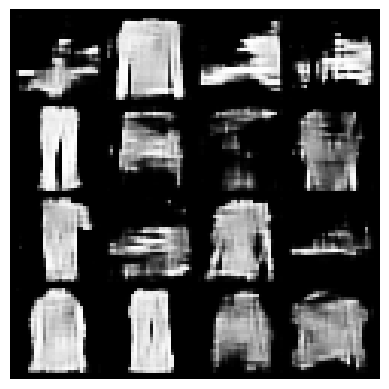

In [36]:
sample()